In [7]:
from scipy.stats import chisquare
#read data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
df = pd.read_csv("/Users/rakeshravi/Documents/Spring/Text Analytics/Project/corpus.csv", sep = "|")

In [10]:
df["doc_source"] = df["doc_source"].astype("category")

In [37]:
div = []
for i in range(500):
    sample = df.sample(50000, random_state=i)
    p = chisquare(sample["doc_source"].value_counts(normalize = True).tolist(), f_exp=df["doc_source"].value_counts(normalize = True).tolist())[0]
    div.append(p)
    if len(div) == 0:
        continue
    if p < min(div):
         break
lowest_div = min(div)

for i in range(500):
    sample = df.sample(50000, random_state=i)
    p = chisquare(sample["doc_source"].value_counts(normalize = True).tolist(), f_exp=df["doc_source"].value_counts(normalize = True).tolist())[0]
    if p <= lowest_div:
        break

In [39]:
#imporiting all libraries
# Run in python console
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rakeshravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# Convert to list
data = sample.doc_content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [41]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [42]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [45]:
# Build LDA model
coher = []
perp = []
for i in range(2,11):
    print(i)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coher.append(coherence_lda)
    perp.append(lda_model.log_perplexity(corpus))

2
3
4
5
6
7
8
9
10


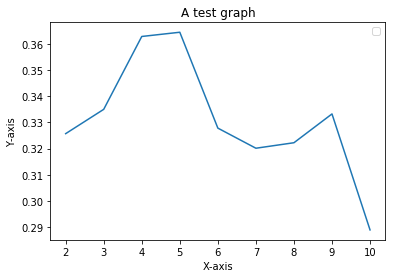

In [49]:
import matplotlib.pyplot as plt
x = [2,3,4,5,6,7,8,9,10]
y = coher
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("A test graph")
plt.plot(x,y)
plt.legend()
plt.show()

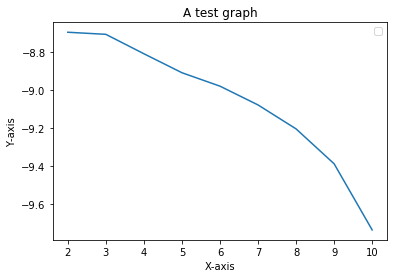

In [50]:
import matplotlib.pyplot as plt
x = [2,3,4,5,6,7,8,9,10]
y = perp
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("A test graph")
plt.plot(x,y)
plt.legend()
plt.show()